## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open ('complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
df['_source.sub_product'].value_counts()


Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Gift or merchant card                             4
Government benefit payment card                   4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: _source.sub_product, Length: 72, dtype: int64

In [7]:
df['_source.issue'].value_counts()

Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Unable to get credit report/credit score                                              1
Advertising, marketing or disclosures                                                 1
Problem with an overdraft                                                             1
Can't stop withdrawals from your bank account                                         1
Money was taken from your bank account on the wrong day or for the wrong amount       1
Name: _source.issue, Length: 154

In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
df.columns = (x.replace("_","").replace("source.","") for x in list(df.columns))

df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely',
       'complaintwhathappened', 'subissue', 'consumerconsentprovided'],
      dtype='object')

In [10]:
df = df.rename(columns={"complaintwhathappened":"complaints"})

In [11]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely', 'complaints',
       'subissue', 'consumerconsentprovided'],
      dtype='object')

In [12]:
df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                     0
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [13]:
sum(df.complaints[:]=="")

57241

In [14]:
#Assign nan in place of blanks in the complaints column
df.complaints.replace("", np.nan , inplace =True)

In [15]:
sum(df.complaints[:]=="")

0

In [16]:
#Remove all rows where complaints column is nan
df.dropna(inplace=True,subset=["complaints"])

In [17]:
df.shape

(21072, 22)

In [18]:
21072/78313*100

26.90741000855541

 #### 26.96% of data is available for further processing .

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
df["complaints"].iloc[7]

'During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, my request for payment extension is granted. I have never been delinquent with my auto loan payment. However, On XX/XX/2019 my request for a one month payment extension was denied this year. I explained my situation to representative and the supervisor with no avail. After a lengthy discussion and waiting, I was informed the reason for the decline as it is not " contractual \'\'. This reason for denial baffled me and therefore I emailed the office of XXXX XXXX Executive Director, Communications, JPMorgan Chase & Co. A representative contacted me and stated Chase will follow-up. About week later a representative of XXXX XXXX XXXX XXXX office called. The representative shared her role was help resolve the matter. The representative via conference call contacted the department handing my request

In [20]:
# Write your function here to clean the text and remove all the unnecessary elements.

def cleanText(text):
    text = text.lower()
    text = re.sub(r'\w*\d\w*',"",text)  # Removing  words containing numbers
    text = re.sub(r'\[|\]',"",text)     # Removing text in square brackets 
    text = re.sub(r'[^\w\s]',"",text)   # Removing punctuation
    return " ".join(text.split())       # Removing unwanted empty spacs 
  

df["complaints"] = df["complaints"].apply(cleanText) 

In [21]:
df["complaints"].iloc[7]

'during the summer months i experience a decline income due to my employment therefore i request a one month payment extension with my auto loan company chase for the past almost fours years my request for payment extension is granted i have never been delinquent with my auto loan payment however on xxxx my request for a one month payment extension was denied this year i explained my situation to representative and the supervisor with no avail after a lengthy discussion and waiting i was informed the reason for the decline as it is not contractual this reason for denial baffled me and therefore i emailed the office of xxxx xxxx executive director communications jpmorgan chase co a representative contacted me and stated chase will followup about week later a representative of xxxx xxxx xxxx xxxx office called the representative shared her role was help resolve the matter the representative via conference call contacted the department handing my request after reviewing my information my 

 - the text now doesnt contain any numbers or brackets , any punctuations and unwanted empty spaces - we can proceed with Lemmatization

In [22]:
#Write your function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [23]:
lemmatization(df["complaints"].iloc[3])

'on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application wa denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only get applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i wa glad i got denied and i wa absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application o

In [83]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['complaints'].swifter.apply(lemmatization)})

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [84]:
df_clean

,complaints,lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...


In [85]:
#!pip install swifter 

In [86]:
import swifter

In [88]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str



#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: pos_tag(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [89]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,xxxx card agent anniversary date agent informa...
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,card application identity consent service cred...
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




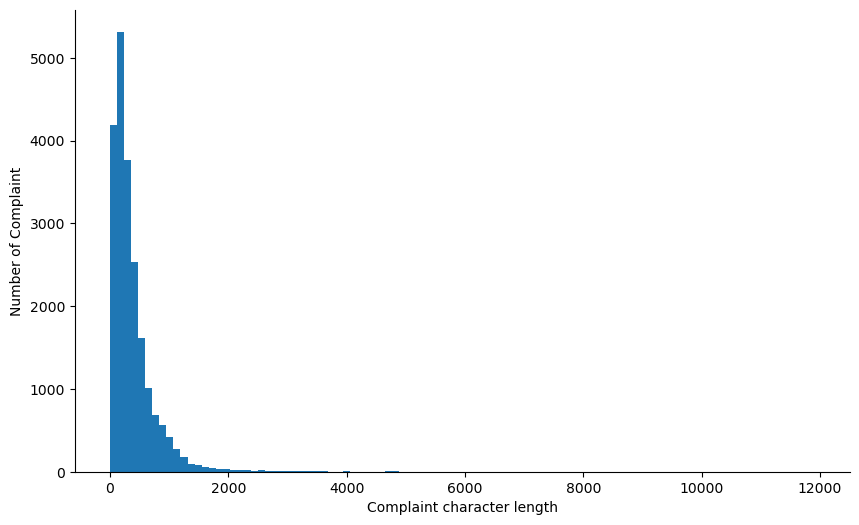

In [90]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

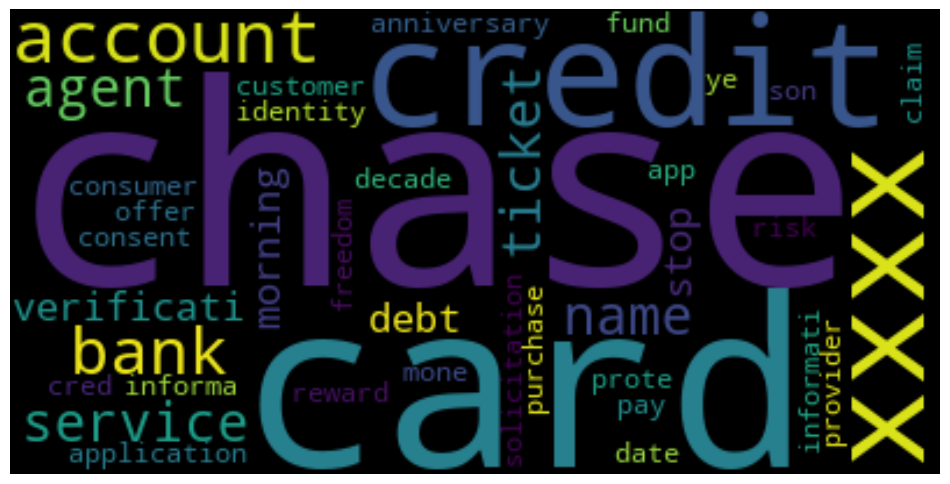

In [91]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [92]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,xxxx card agent anniversary date agent informa...,xxxx card agent anniversary date agent informa...
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,card application identity consent service cred...,card application identity consent service cred...
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,xxxx ticket offer ticket reward card informati...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx pay risk consumer chase bank app chase ye...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [93]:
def get_top_ngrams(text, n=None, ngram=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
    bagofwords = vec.transform(text)
    sum_words = bagofwords.sum(axis=0)
    words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
    return words_frequency[:n]

In [94]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,chase,51190
1,account,46332
2,xxxx,35006
3,credit,32559
4,card,30083
5,payment,21167
6,bank,20690
7,time,16037
8,day,13184
9,money,11954


In [95]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)


,unigram,count
0,chase,51190
1,account,46332
2,xxxx,35006
3,credit,32559
4,card,30083
5,payment,21167
6,bank,20690
7,time,16037
8,day,13184
9,money,11954


In [96]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12834
1,credit report,3842
2,account chase,3123
3,customer service,3056
4,chase account,2897
5,chase credit,2884
6,account account,2677
7,bank account,2507
8,xxxx xxxx,2476
9,chase bank,2052


In [97]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12834
1,credit report,3842
2,account chase,3123
3,customer service,3056
4,chase account,2897
5,chase credit,2884
6,account account,2677
7,bank account,2507
8,xxxx xxxx,2476
9,chase bank,2052


In [98]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,1915
1,credit card account,1129
2,credit card company,998
3,credit card chase,776
4,xxxx credit card,756
5,credit card credit,557
6,inquiry credit report,512
7,account credit card,445
8,card credit card,444
9,credit card xxxx,409


In [99]:
#Print the top 10 words in the trigram frequency

df_trigram.head(10)



,trigram,count
0,chase credit card,1915
1,credit card account,1129
2,credit card company,998
3,credit card chase,776
4,xxxx credit card,756
5,credit card credit,557
6,inquiry credit report,512
7,account credit card,445
8,card credit card,444
9,credit card xxxx,409


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [100]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [101]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,card application identity consent service cred...,card application identity consent service cred...
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,pay risk consumer chase bank app chase year b...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [102]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [103]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


In [104]:
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [105]:
dtm

<21072x6052 sparse matrix of type '<class 'numpy.float64'>'
	with 548238 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [106]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [107]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 
#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)#write your code here

In [108]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6052

In [109]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,fee,checking,business,number,transaction,customer
Topic 2,card,credit,chase,balance,account,fee,limit,score,year,month,purchase,point,offer,service,reason
Topic 3,payment,loan,mortgage,chase,month,home,modification,time,year,rate,balance,property,fee,statement,day
Topic 4,inquiry,report,credit,company,information,bureau,reporting,debt,identity,score,theft,account,letter,application,file
Topic 5,charge,chase,transaction,dispute,claim,fraud,merchant,letter,email,service,information,company,time,phone,purchase


In [110]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
#topic_results.argmax(axis=1)


In [111]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)
#write your code to assign topics to each rows.

In [52]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,card application identity consent service cred...,card application identity consent service cred...,1
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [112]:
#Print the first 5 Complaint for each of the Topics
df_clean_five=df_clean.groupby('Topic').head(5)
df_clean_five.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
24,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account chase auto xxxx,account chase auto,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
27,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,account bank code xxxxxxxx term everything acc...,account bank code term everything account de...,0
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,1
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,card application identity consent service cred...,card application identity consent service cred...,1
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase catering order brother funeral amount ch...,chase catering order brother funeral amount ch...,1
50,i am a senior citizen that has been scammed by...,i am a senior citizen that ha been scammed by ...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [113]:
df_clean.shape

(21072, 5)

In [114]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
#Replace Topics with Topic Names
df_clean=df_clean.replace({"Topic": Topic_names})


In [115]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,Account Services
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Others
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,card application identity consent service cred...,card application identity consent service cred...,Others
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Account Services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Others
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,pay risk consumer chase bank app chase year b...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [116]:
#Create the dictionary again of Topic names and Topics

Topic_numbers = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
#Replace Topics names with Numbers 

df_clean=df_clean.replace({"Topic": Topic_numbers})


In [117]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,card application identity consent service cred...,card application identity consent service cred...,1
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,4
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,pay risk consumer chase bank app chase year b...,4
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,1


In [118]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean.drop(['lemmatized', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [119]:
training_data

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,1
10,chase card was reported on xxxx however fraudu...,1
11,on xxxx while trying to book a xxxx xxxx ticke...,3
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,4
78310,i am not familiar with xxxx pay and did not un...,4
78311,i have had flawless credit for yrs ive had cha...,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [120]:
from sklearn.feature_extraction.text import TfidfTransformer

In [121]:

#Write your code to get the Vector count

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)
#Write your code here to transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [122]:
X_train_tfidf

<21072x33772 sparse matrix of type '<class 'numpy.float64'>'
	with 2283575 stored elements in Compressed Sparse Row format>

In [63]:
training_data.Topic

1     0
2     1
10    1
11    3
14    0
15    3
17    0
20    2
21    4
23    3
24    0
26    3
27    0
32    1
40    1
43    4
45    4
48    4
50    1
57    2
58    2
73    2
78    4
81    2
83    3
Name: Topic, dtype: int64

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [123]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

In [126]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], train_size=0.9, random_state=42)

In [130]:
y_test

30957    2
58320    4
61282    2
40500    1
54027    4
        ..
11961    3
53768    2
30515    0
43358    2
54345    2
Name: Topic, Length: 2108, dtype: int64

In [131]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted,zero_division=1))

#print (accuracy_score(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       513
           1       0.95      0.90      0.92       409
           2       0.94      0.95      0.95       501
           3       0.94      0.90      0.92       212
           4       0.90      0.91      0.91       473

    accuracy                           0.93      2108
   macro avg       0.93      0.92      0.93      2108
weighted avg       0.93      0.93      0.93      2108



D:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [132]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test,zero_division=0))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       513
           1       0.77      0.77      0.77       409
           2       0.84      0.84      0.84       501
           3       0.73      0.77      0.75       212
           4       0.71      0.67      0.69       473

    accuracy                           0.77      2108
   macro avg       0.77      0.77      0.77      2108
weighted avg       0.77      0.77      0.77      2108



In [133]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test , zero_division=0))

              precision    recall  f1-score   support

           0       0.64      0.93      0.76       513
           1       0.79      0.55      0.65       409
           2       0.71      0.93      0.80       501
           3       1.00      0.24      0.39       212
           4       0.79      0.60      0.68       473

    accuracy                           0.71      2108
   macro avg       0.78      0.65      0.66      2108
weighted avg       0.75      0.71      0.69      2108



In [134]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.41      0.31      0.35       513
           1       0.28      0.37      0.32       409
           2       0.55      0.40      0.46       501
           3       0.29      0.64      0.40       212
           4       0.38      0.27      0.32       473

    accuracy                           0.37      2108
   macro avg       0.38      0.40      0.37      2108
weighted avg       0.40      0.37      0.37      2108



In [146]:
df['complaints'].iloc[345]

'i received balance transfer checks on my united card the notice told me that i could get cash no where did it put limits that disclosure i wasnt allowed to send it to anyone for them to get cash and when i went to just get cash to me it could only deposit it to another account with a day hold and not get cash maybe im odd but cash is where i can go to a branch and just cash the check and received dollar bills my original recipient couldnt cash the check drawn on my chase account and when i just tried to cash the check and give the recipient cash neither could i get cash ie dollar bills etc fix your disclosure if you cant get cash then dont state that in the letter'

In [71]:
# Some sample complaints to infer model


,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [147]:
df_complaints=pd.DataFrame({'complaints':["on xxxx xxxx some one cashed a forged check in the amount of on xxxx xxxx when the check posted on our account we first contacted chase and informed them of the fraudulent activity then immediately filed a police report with xxxx police department case xxxx with xxxx xxxx chase informed us it would take up to days to investigate and return the funds on the xxxx we contacted chase to get an update on the claim and they informed us the claim was denied they would not refund our money because we were negligent with our checks that we didnt keep our checks in a safe at all times my husband went to the local branch to discuss this matter further and the banker herself said she has never kept her checks in a safe ever",
                                       "i sent to wrong person using chase quickpay service although name was correct but phone number was old for the recipient i was under the impression that both phone number and name will be authenticated because when i make similar transaction at xxxx xxxx xxxx it checks for name as well",
                                       "hello yesterday i changed my quickpay with chase and had my sister send it to my second bank account with chase my sister sent an quickpay to chase and the default account did not change i went to the bank and they can see it had been changed on my end in their system but when i call the xxxx number they ca nt see that change and the second account i had with them is in the negative so i could not just transfer the money they said it is nothing they could do about it",
                                        "i received balance transfer checks on my united card the notice told me that i could get cash no where did it put limits that disclosure i wasnt allowed to send it to anyone for them to get cash and when i went to just get cash to me it could only deposit it to another account with a day hold and not get cash maybe im odd but cash is where i can go to a branch and just cash the check and received dollar bills my original recipient couldnt cash the check drawn on my chase account and when i just tried to cash the check and give the recipient cash neither could i get cash ie dollar bills etc fix your disclosure if you cant get cash then dont state that in the letter",  
                                       "did a balance trasfer with chase the terms were no interst on the transfer and pay your regular charges i did they still charge me instrest this is a fraud company that lies to consumers"]})

In [140]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [148]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,on xxxx xxxx some one cashed a forged check in...,Account Services
1,i sent to wrong person using chase quickpay se...,Theft/Dispute Reporting
2,hello yesterday i changed my quickpay with cha...,Account Services
3,i received balance transfer checks on my unite...,Account Services
4,did a balance trasfer with chase the terms wer...,Theft/Dispute Reporting


## Conclusion
    
* **As expected 5 topics were indetified namely:**
    1. Account Services
    2. Others
    3. Mortgage/Loan
    4. Credit card or prepaid card
    5. Theft/Dispute Reporting
    
    
* **Tried 4 models on the data with accuracies as follows:**

    | Model       | Accuracy |
    | ----------- | ----------- |
    | Logistic Regression      | 0.93       |
    | Decision Tree   | 0.77        |
    | Random Forest      | 0.71       |
    | Naive Bayes   | 0.37       |
    
 <br /> <br /> <br /> <br /><br /> <br /><br />
* **Logistic Regression has highest accuracy of `0.93`, Hence is a good fit for this particular case study.**